[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`. 

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

In [1]:
import torch

input = torch.randn(64, 10, 20, 20)
# aumentamos la dimensión x2
conv_trans = torch.nn.ConvTranspose2d(
    in_channels=10, 
    out_channels=20, 
    kernel_size=2, 
    stride=2)
output = conv_trans(input)
output.shape

torch.Size([64, 20, 40, 40])

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

In [3]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
wget.download(url)

'MRIs (6).zip'

In [4]:
import zipfile
with zipfile.ZipFile('MRIs.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca. Determinar la cantidad de ambas así como su evolución en el tiempo para un mismo paciente es clave para la detección temprana y tratamiento de enfermedades como el alzheimer. 

In [5]:
import os 
from pathlib import Path

path = Path('./MRIs')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

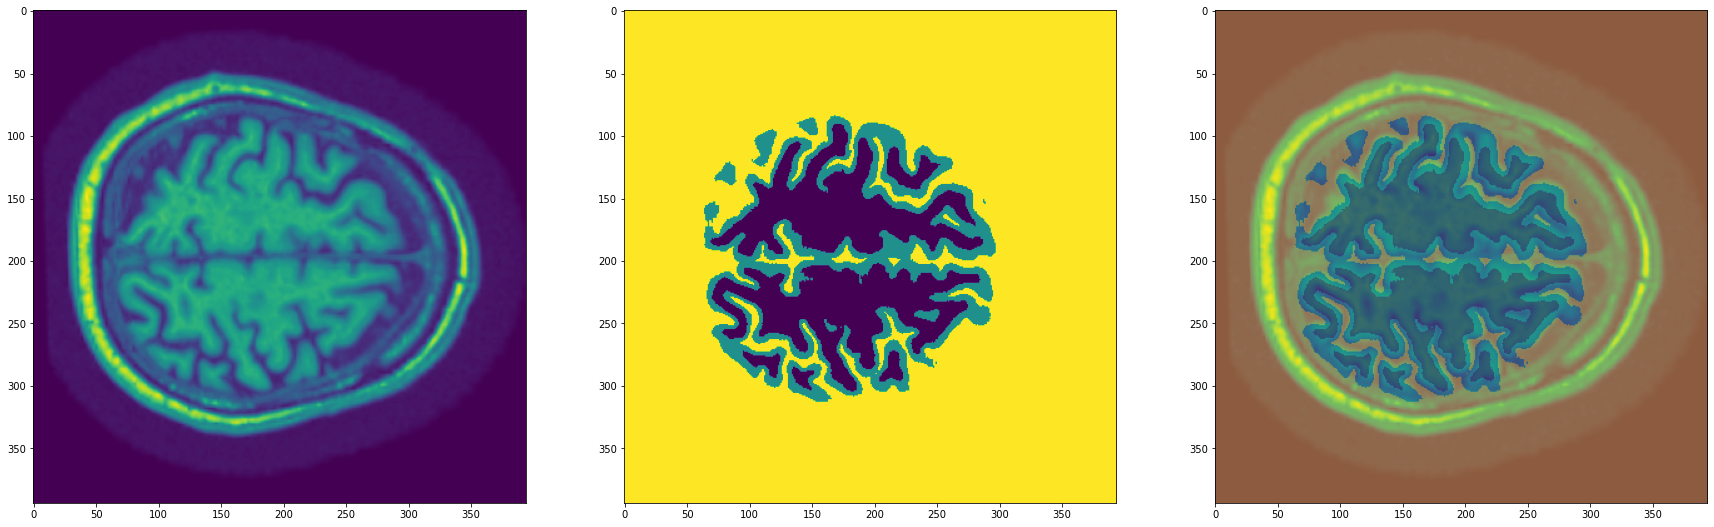

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [7]:
img.shape, img.dtype, img.max(), img.min()

((394, 394), dtype('float32'), 1.0093316, 0.00025629325)

En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [8]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [9]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

## UNet

Vamos ahora a implementar nuestra red neuronal similar a `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [10]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [11]:
model = UNet()
output = model(torch.randn((10,1,394,394)))
output.shape

torch.Size([10, 3, 394, 394])

## Fit de 1 muestra

Para comprobar que todo funciona vamos a hacer el fit de una sola muestra. Para optimizar la red usamos la función de pérdida `BCEWithLogitsLoss`, que aplicará la función de activación `sigmoid` a las salidas de la red (para que estén entre 0 y 1) y luego calcula la función `binary cross entropy`.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [13]:
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 1, 394, 394]), torch.Size([1, 3, 394, 394]))

In [14]:
fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/20 loss 0.75874
Epoch 2/20 loss 0.73327
Epoch 3/20 loss 0.71612
Epoch 4/20 loss 0.70197
Epoch 5/20 loss 0.68919
Epoch 6/20 loss 0.67762
Epoch 7/20 loss 0.66688
Epoch 8/20 loss 0.65657
Epoch 9/20 loss 0.64672
Epoch 10/20 loss 0.63741
Epoch 11/20 loss 0.62850
Epoch 12/20 loss 0.61983
Epoch 13/20 loss 0.61144
Epoch 14/20 loss 0.60338
Epoch 15/20 loss 0.59573
Epoch 16/20 loss 0.58832
Epoch 17/20 loss 0.58104
Epoch 18/20 loss 0.57385
Epoch 19/20 loss 0.56678
Epoch 20/20 loss 0.55984


La función de pérdida va bajando, por lo que parece que está funcionando bien. Sin embargo, necesitamos alguna métrica para evaluar cuánto se parecen las máscaras predichas a las reales. Para ello podemos usar la métrica `IoU`, de la que ya hablamos anteriormente, y que calcula la relación entre la intersección y la unión de dos áreas.

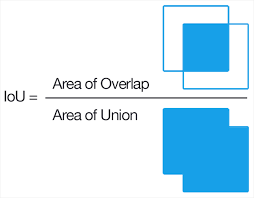

In [15]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [16]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [17]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.55302 iou 0.25259
Epoch 2/100 loss 0.53576 iou 0.26911
Epoch 3/100 loss 0.50940 iou 0.31764
Epoch 4/100 loss 0.48882 iou 0.32311
Epoch 5/100 loss 0.46794 iou 0.32404
Epoch 6/100 loss 0.44806 iou 0.33351
Epoch 7/100 loss 0.42920 iou 0.33803
Epoch 8/100 loss 0.41053 iou 0.35249
Epoch 9/100 loss 0.39280 iou 0.35613
Epoch 10/100 loss 0.37601 iou 0.35847
Epoch 11/100 loss 0.36058 iou 0.35473
Epoch 12/100 loss 0.34442 iou 0.36439
Epoch 13/100 loss 0.32898 iou 0.36210
Epoch 14/100 loss 0.31499 iou 0.35568
Epoch 15/100 loss 0.30218 iou 0.35726
Epoch 16/100 loss 0.28931 iou 0.35301
Epoch 17/100 loss 0.27749 iou 0.35892
Epoch 18/100 loss 0.26667 iou 0.36389
Epoch 19/100 loss 0.25610 iou 0.35207
Epoch 20/100 loss 0.24597 iou 0.35379
Epoch 21/100 loss 0.23667 iou 0.35448
Epoch 22/100 loss 0.22762 iou 0.35760
Epoch 23/100 loss 0.21958 iou 0.34974
Epoch 24/100 loss 0.21201 iou 0.37263
Epoch 25/100 loss 0.20361 iou 0.35450
Epoch 26/100 loss 0.19585 iou 0.36176
Epoch 27/100 loss 0.1

Ahora podemos generar predicciones para obtener máscaras de segmentación

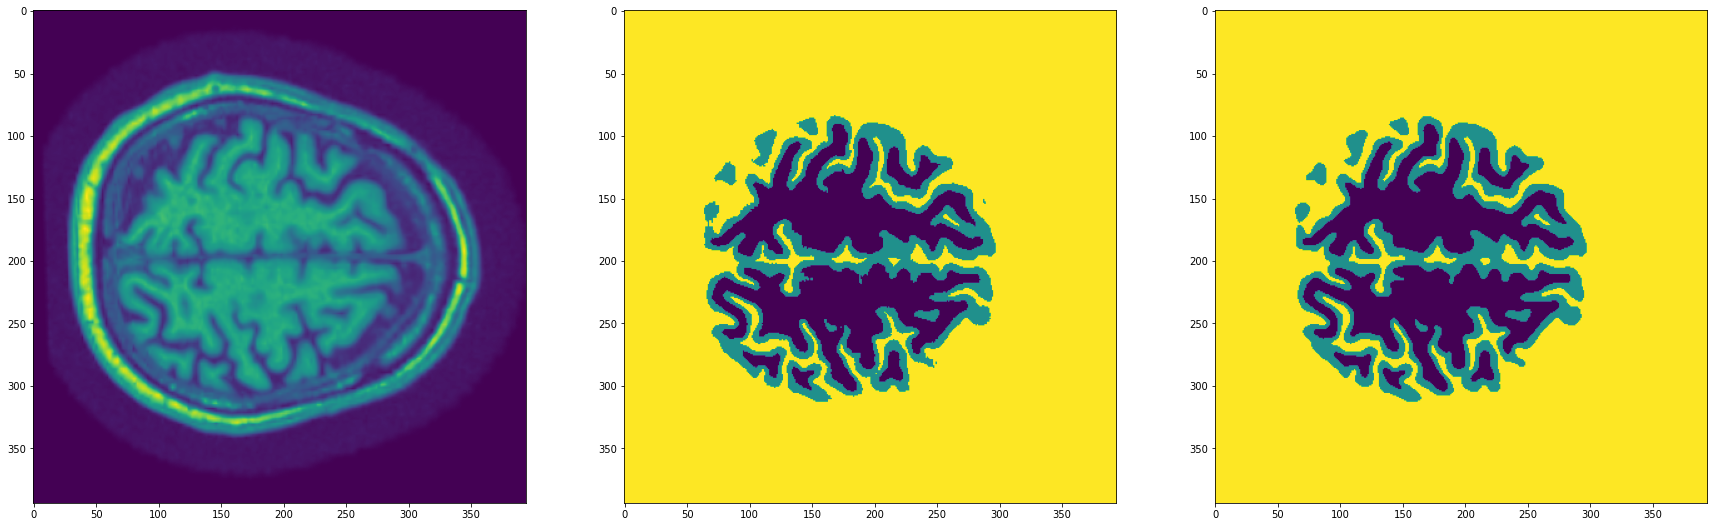

In [18]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Entrenando con todo el dataset

Una vez hemos validado que nuestra red es capaz de hacer el fit de una imágen, podemos entrenar la red con todo el dataset.

In [19]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    img = torch.tensor(img).unsqueeze(0) 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [20]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

In [21]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 1, 394, 394]), torch.Size([16, 3, 394, 394]))

In [22]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [23]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1/30 loss 0.58465 iou 0.24777 test_loss 0.66385 test_iou 0.08055


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2/30 loss 0.44370 iou 0.35166 test_loss 0.44325 test_iou 0.22360


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3/30 loss 0.33856 iou 0.37663 test_loss 0.31273 test_iou 0.35562


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 4/30 loss 0.26632 iou 0.35184 test_loss 0.25799 test_iou 0.31275


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 5/30 loss 0.22021 iou 0.34264 test_loss 0.21266 test_iou 0.34532


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 6/30 loss 0.19001 iou 0.33456 test_loss 0.18822 test_iou 0.32341


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 7/30 loss 0.17054 iou 0.33296 test_loss 0.17809 test_iou 0.36312


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 8/30 loss 0.15606 iou 0.32807 test_loss 0.16123 test_iou 0.33658


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 9/30 loss 0.14524 iou 0.32532 test_loss 0.15319 test_iou 0.35027


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 10/30 loss 0.13672 iou 0.32426 test_loss 0.13999 test_iou 0.31109


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 11/30 loss 0.12915 iou 0.32757 test_loss 0.13609 test_iou 0.34004


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 12/30 loss 0.12244 iou 0.34689 test_loss 0.13023 test_iou 0.38826


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 13/30 loss 0.11529 iou 0.42372 test_loss 0.11933 test_iou 0.45713


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 14/30 loss 0.10654 iou 0.59694 test_loss 0.11057 test_iou 0.61693


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 15/30 loss 0.09833 iou 0.69466 test_loss 0.10249 test_iou 0.69836


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 16/30 loss 0.09082 iou 0.73460 test_loss 0.09946 test_iou 0.71532


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 17/30 loss 0.08657 iou 0.74121 test_loss 0.09268 test_iou 0.71660


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 18/30 loss 0.08128 iou 0.75008 test_loss 0.09066 test_iou 0.72135


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 19/30 loss 0.07691 iou 0.75876 test_loss 0.08661 test_iou 0.72849


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 20/30 loss 0.07308 iou 0.76545 test_loss 0.08892 test_iou 0.71451


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 21/30 loss 0.07026 iou 0.77062 test_loss 0.07957 test_iou 0.74376


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 22/30 loss 0.06722 iou 0.77535 test_loss 0.07786 test_iou 0.74443


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 23/30 loss 0.06689 iou 0.77016 test_loss 0.08267 test_iou 0.70844


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 24/30 loss 0.06428 iou 0.77814 test_loss 0.08776 test_iou 0.69124


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 25/30 loss 0.06285 iou 0.77859 test_loss 0.07437 test_iou 0.74376


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 26/30 loss 0.06006 iou 0.78755 test_loss 0.07426 test_iou 0.74887


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 27/30 loss 0.05860 iou 0.78809 test_loss 0.08566 test_iou 0.68627


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 28/30 loss 0.05978 iou 0.78113 test_loss 0.08229 test_iou 0.72106


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 29/30 loss 0.05583 iou 0.79455 test_loss 0.07082 test_iou 0.74957


test_loss 0.06794 test_iou 0.75993: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 30/30 loss 0.05405 iou 0.79965 test_loss 0.06794 test_iou 0.75993


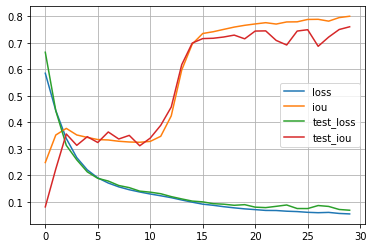

In [24]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Transfer Learning

Podemos mejorar nuestros resultados si en vez de entrenar nuestra `UNet` desde cero utilizamos una red ya entrenada gracias al `transfer learning`. Para ello usaremos `ResNet` como `backbone` en el `encoder` de la siguiente manera.

In [25]:
import torchvision

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [26]:
model = UNetResnet()
output = model(torch.randn((10,1,394,394)))
output.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([10, 3, 394, 394])

In [27]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1/30 loss 0.47066 iou 0.45623 test_loss 0.60641 test_iou 0.01456


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2/30 loss 0.35038 iou 0.67440 test_loss 0.42464 test_iou 0.39127


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3/30 loss 0.30075 iou 0.71694 test_loss 0.30222 test_iou 0.69314


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 4/30 loss 0.26497 iou 0.73379 test_loss 0.25938 test_iou 0.72612


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 5/30 loss 0.23624 iou 0.74012 test_loss 0.23491 test_iou 0.72937


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 6/30 loss 0.20994 iou 0.75800 test_loss 0.20987 test_iou 0.74493


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 7/30 loss 0.18746 iou 0.77275 test_loss 0.19024 test_iou 0.72724


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 8/30 loss 0.16708 iou 0.79054 test_loss 0.16811 test_iou 0.77223


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 9/30 loss 0.15104 iou 0.79656 test_loss 0.15827 test_iou 0.74552


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 10/30 loss 0.13568 iou 0.81250 test_loss 0.14146 test_iou 0.77153


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 11/30 loss 0.12258 iou 0.82557 test_loss 0.13118 test_iou 0.78280


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 12/30 loss 0.11054 iou 0.84057 test_loss 0.12378 test_iou 0.77133


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 13/30 loss 0.10152 iou 0.84445 test_loss 0.11357 test_iou 0.78920


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 14/30 loss 0.09361 iou 0.85029 test_loss 0.10501 test_iou 0.79471


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 15/30 loss 0.08632 iou 0.85522 test_loss 0.09837 test_iou 0.79835


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 16/30 loss 0.07982 iou 0.86331 test_loss 0.09293 test_iou 0.80176


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 17/30 loss 0.07276 iou 0.87574 test_loss 0.08955 test_iou 0.80167


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 18/30 loss 0.06838 iou 0.87643 test_loss 0.09200 test_iou 0.77620


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 19/30 loss 0.06482 iou 0.87562 test_loss 0.08966 test_iou 0.77144


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 20/30 loss 0.06162 iou 0.87547 test_loss 0.08233 test_iou 0.79512


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 21/30 loss 0.05877 iou 0.87692 test_loss 0.08195 test_iou 0.78903


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 22/30 loss 0.05420 iou 0.88820 test_loss 0.07881 test_iou 0.79599


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 23/30 loss 0.05144 iou 0.88951 test_loss 0.07565 test_iou 0.80191


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 24/30 loss 0.04932 iou 0.88933 test_loss 0.07559 test_iou 0.79975


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 25/30 loss 0.04772 iou 0.88783 test_loss 0.07180 test_iou 0.80552


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 26/30 loss 0.04463 iou 0.89550 test_loss 0.07281 test_iou 0.79339


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 27/30 loss 0.04281 iou 0.89712 test_loss 0.07053 test_iou 0.80255


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 28/30 loss 0.03986 iou 0.90592 test_loss 0.07449 test_iou 0.78764


  0%|          | 0/21 [00:00<?, ?it/s]


Epoch 29/30 loss 0.03961 iou 0.89910 test_loss 0.06947 test_iou 0.80261


test_loss 0.06850 test_iou 0.80490: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch 30/30 loss 0.03741 iou 0.90543 test_loss 0.06850 test_iou 0.80490


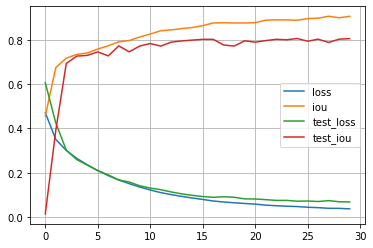

In [28]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

En este caso observamos como la red converge más rápido, sin embargo no obtenemos una gran mejora de prestaciones ya que nuestro dataset es muy pequeño y la naturaleza de las imágenes es muy distinta a las utilizadas para entrenar `ResNet`. Podemos generar máscaras para imágenes del dataset de test de la siguiente manera.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


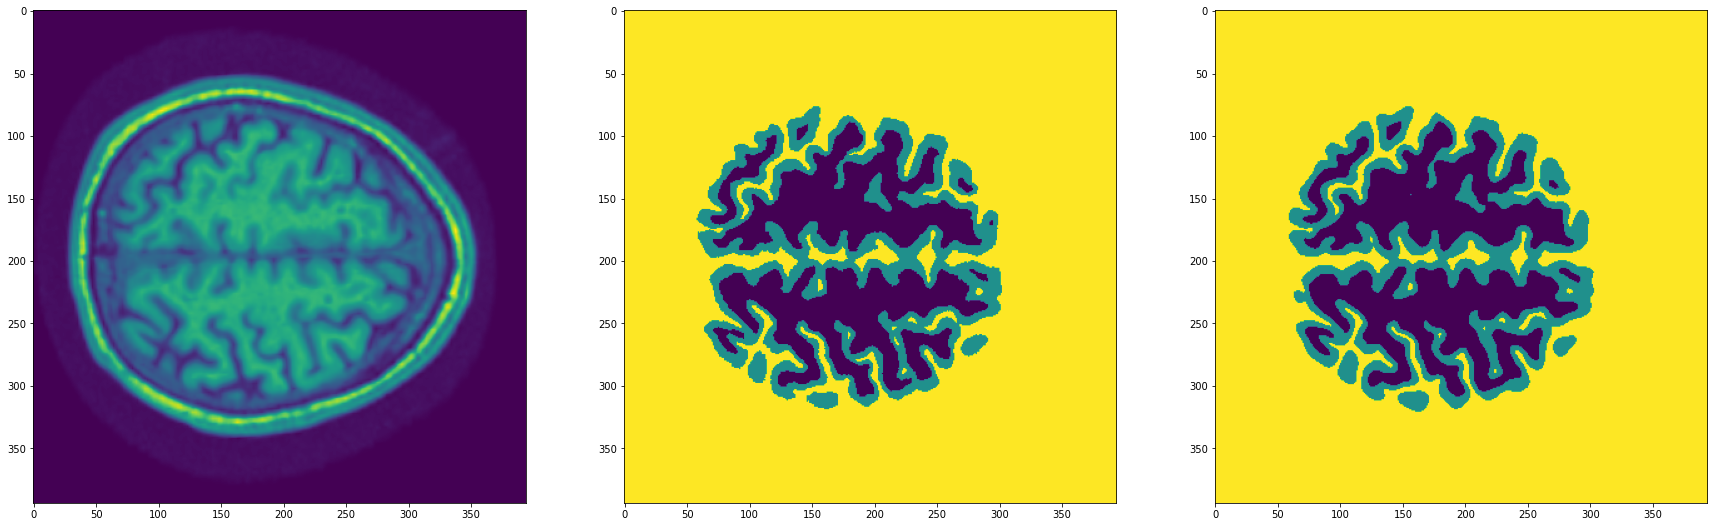

In [30]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Resumen

En este post hemos visto como podemos implementar y entrenar una red convolucional para llevar a cabo la tarea de segmentación semántica. Esta tarea consiste en clasificar todos y cada uno de los píxeles en una imagen. De esta manera podemos producir máscaras de segmentación que nos permiten localizar los diferentes objetos presentes en una imagen de forma mucho más precisa que la que podemos conseguir con la detección de objetos. Este tipo de tarea puede utilizarse en aplicaciones como la conducción autónoma o sistemas de diagnóstico médico, como hemos visto en el ejemplo de este post.